In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [183]:
class SPNet(nn.Module):
    def __init__(self, N=8, has_key=True):
        super(SPNet, self).__init__()
        self.N = N

        self.fc1   = nn.Linear(in_features=N+4 if has_key else 4, out_features=4+N)
        self.fc2   = nn.Linear(in_features=N+4, out_features=N) ## 2*N????
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)
        
    def forward(self, x):
        #print(x.size())
        x = torch.sigmoid( self.fc1(x) )
        #print(x.size())
        x = torch.sigmoid( self.fc2(x) )
        #print(x.size())
        x = x.view(-1, 1, self.N)
        #print(x.size())
        x = torch.sigmoid( self.conv1(x) )
        #print(x.size())
        x = torch.sigmoid( self.conv2(x) )
        #print(x.size())
        x = torch.sigmoid( self.conv3(x) )
        #print(x.size())
        x = torch.tanh(    self.conv4(x) )
        #print(x.size())
        x = x.view(-1, 4)
        #print(x.size())
        return x

In [5]:
minibatch_size = 4096 # [256..4096]

In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [185]:
square_error = lambda C1, C: torch.mean( torch.pow( C1 - C, 2) )
cov = lambda x, y: torch.mean( (x - x.mean()) * (y - y.mean()) )

loss_eve = square_error # on the single term C
loss_alicebob = (lambda public_error, bob_error, C_eve, C: 
    # square_error(D_pub, D) + square_error(D_bob, D)
      public_error           + bob_error
    + torch.abs( cov(C_eve, C) ))

In [141]:
# correlation matrix (symmetric positive definite matrix with ones in the diagonal)
C = torch.rand(size=(4,4), dtype=torch.float)
C = C - C*torch.eye(4) + torch.eye(4)
C = C * C.T
L = torch.cholesky(C).to(DEVICE)

# gen data example
K = torch.randint(low=0, high=2, size=(minibatch_size, 8), dtype=torch.float).to(DEVICE)*2-1
uncorrelated_ABCD = torch.randn(size=(minibatch_size, 4), dtype=torch.float).to(DEVICE)
ABCD = uncorrelated_ABCD @ L
ABCD

tensor([[ 1.5498, -1.9953,  0.4826, -0.4022],
        [ 0.1954,  0.1145,  0.6944,  0.6652],
        [-1.1558,  0.2236, -1.5166,  0.3414],
        ...,
        [-0.3483,  0.3847, -0.3438, -0.1764],
        [-1.0419, -0.0525, -1.0400,  0.8917],
        [-0.8600, -2.4994, -0.0464,  0.4576]], device='cuda:0')

In [188]:
max_iter = 150000
ABs = []
Es  = []
PEs = []
BEs = []

A = SPNet(has_key=True).to(DEVICE)
B = SPNet(has_key=True).to(DEVICE)
E = SPNet(has_key=False).to(DEVICE)
#BE = SPNet(has_key=???).to(DEVICE) # Blind_Eve  is aware of the distribution of C ???

A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
E_optimizer = optim.Adam(E.parameters(), lr=0.0008)

A.train()
B.train()
E.train()

for ic in range(max_iter):
    for who, num_minibatches in [('AB', 1), ('E', 2)]:
        for _ in range(num_minibatches):
            K = torch.randint(low=0, high=2, size=(minibatch_size, 8), dtype=torch.float).to(DEVICE)*2-1
            uncorrelated_ABCD = torch.randn(size=(minibatch_size, 4), dtype=torch.float).to(DEVICE)
            ABCD = uncorrelated_ABCD @ L
            C = ABCD[:,2]
            D = ABCD[:,3]
            
            DENC = A(torch.cat((ABCD, K), dim=1))
            BOBD = B(torch.cat((DENC, K), dim=1))
            EVEC = E(DENC)

            D_pub = DENC[:,3] # 4th col is D
            D_bob = BOBD[:,3]
            C_eve = EVEC[:,2] # 3rd col is C
            
            if who == 'AB':
                public_error = square_error(D_pub, D)
                bob_error = square_error(D_bob, D)
                AB_loss = loss_alicebob(public_error, bob_error, C_eve, C)
                A_optimizer.zero_grad()
                B_optimizer.zero_grad()
                AB_loss.backward()
                A_optimizer.step()
                B_optimizer.step()

            if who == 'E':
                E_loss = loss_eve(C_eve, C)
                E_optimizer.zero_grad()
                E_loss.backward()
                E_optimizer.step()

    if ic % 1000 == 999:
        print("[{:6d}] PE {:2.4f} BE {:2.4f} AB_loss: {:2.4f} E_loss: {:2.4f}".format(ic+1, public_error, bob_error, AB_loss, E_loss))
    ABs.append(AB_loss.item())
    Es.append(E_loss.item())
    PEs.append(public_error.item())
    BEs.append(bob_error.item())
    if AB_loss < 0.005 and E_loss > 0.5: # AB_loss < 0.05 and E_loss > 2
        break
                
            

[  1000] PE 0.4687 BE 0.7839 AB_loss: 1.2526 E_loss: 0.7582


[  2000] PE 0.1640 BE 0.1478 AB_loss: 0.3334 E_loss: 0.7736


[  3000] PE 0.1240 BE 0.1166 AB_loss: 0.2587 E_loss: 0.7485


[  4000] PE 0.1094 BE 0.1056 AB_loss: 0.2354 E_loss: 0.7453


[  5000] PE 0.1080 BE 0.1059 AB_loss: 0.2339 E_loss: 0.7787


[  6000] PE 0.0996 BE 0.0983 AB_loss: 0.2172 E_loss: 0.7204


[  7000] PE 0.1086 BE 0.1076 AB_loss: 0.2375 E_loss: 0.7463


[  8000] PE 0.1034 BE 0.1026 AB_loss: 0.2261 E_loss: 0.7389


[  9000] PE 0.0904 BE 0.0898 AB_loss: 0.1986 E_loss: 0.7792


[ 10000] PE 0.0961 BE 0.0956 AB_loss: 0.2104 E_loss: 0.7762


[ 11000] PE 0.0915 BE 0.0911 AB_loss: 0.2018 E_loss: 0.7693


[ 12000] PE 0.0979 BE 0.0975 AB_loss: 0.2138 E_loss: 0.7339


[ 13000] PE 0.1041 BE 0.1038 AB_loss: 0.2247 E_loss: 0.7684


[ 14000] PE 0.1001 BE 0.0999 AB_loss: 0.2201 E_loss: 0.7721


[ 15000] PE 0.1045 BE 0.1042 AB_loss: 0.2301 E_loss: 0.7418


[ 16000] PE 0.1015 BE 0.1012 AB_loss: 0.2214 E_loss: 0.7359


[ 17000] PE 0.1078 BE 0.1075 AB_loss: 0.2343 E_loss: 0.7411


[ 18000] PE 0.0977 BE 0.0976 AB_loss: 0.2137 E_loss: 0.7679


[ 19000] PE 0.1151 BE 0.1149 AB_loss: 0.2504 E_loss: 0.7540


[ 20000] PE 0.1106 BE 0.1104 AB_loss: 0.2418 E_loss: 0.7373


KeyboardInterrupt: 

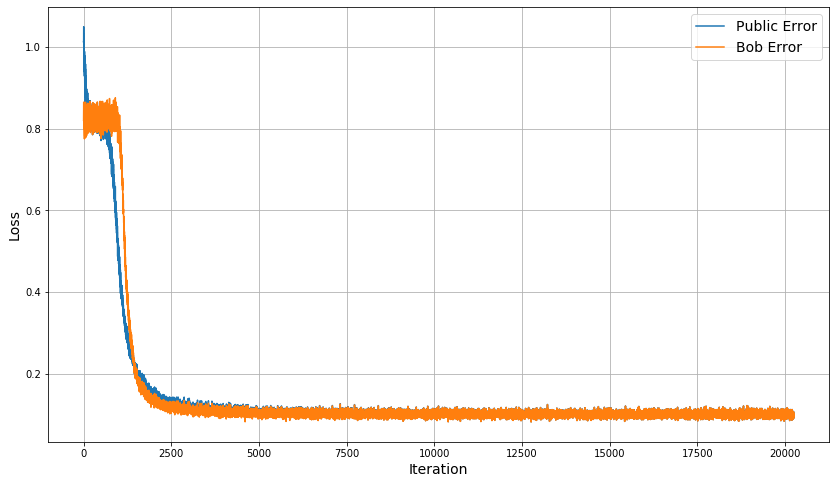

In [189]:
plt.figure(figsize=(14,8))
#plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
#plt.plot(range(1, len(Es)+1), Es, label='Eve')
plt.plot(range(1, len(PEs)+1), PEs, label='Public Error')
plt.plot(range(1, len(BEs)+1), BEs, label='Bob Error')
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which='both')
plt.show()